<a href="https://colab.research.google.com/github/kiddhcx/MODE/blob/master/MODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODE

In [4]:
import tensorflow as tf
import keras as k
import numpy as np
import matplotlib.pyplot as plt

# personal modules
from distance_metrics import bhattacharyya
from eval import get_eval_datasets, replicate_model
from layer_selection import (Forward_Layer_Select, 
                                calculate_acc_for_labels, 
                                get_overfit_labels, 
                                get_underfit_labels,
                                get_faultiest_label)
from heatmap import get_heatmaps
from input_selection import select_next_inputs
from visualizations import (get_plot, 
                               visualize_array, 
                               get_samples_for_label,
                               sample_misclassifications, 
                               viz_heatmaps_for_correct_prediction, 
                               viz_heatmaps_for_false_positives, 
                               viz_heatmaps_for_false_negatives,
                               DHCI_i_k,
                               DHMI_i,
                               DHWI_i,
                               viz_most_least_similar,
                               viz_most_similar,
                               viz_least_similar)

# plot defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.insert(0,'/content/drive/My Drive/MODE')

### References

https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers

### Parameters

In [22]:
# Underfitting Threshold
# Both the training accuracy (TrAcc)  and the testing accuracy (TeAcc)
# must be lower than this param to qualify as underfitting
theta = 0.75

# Overfitting Threshold
# The difference between the training accuracy (TrAcc) and testing accuracy (TeAcc)
# must be larger than this param to qualify as overfitting
gamma = 0.10

# Ratio between Selected Data and Random Data 
# Controls the ratio of the target class to fix and the random other classes 
# trained simultaneosly. 
# TODO: find a way to experiment with setting this automatically based on the 
# number of classes in your task. 
# TODO: see if we can use larger alpha and reduced batch sizes to control overfitting
alpha = 0.25

# Byattacharyya Distance
# If the distribution of two y_pred matrices are less than this amount, than they are
# sufficiently similar and we'll take the layer that produced the distribution first
similarity_threshold = 0.01

# Number of Epochs
# TODO: implement early stopping
epochs = 3

# Batch Size
batch_size = 2000 # they used 2000 and 4000 in the paper

### Data

In [6]:
# download MNIST
mnist = tf.keras.datasets.fashion_mnist

# split into test and train sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize to [0,1] by dividing by the max value
x_train, x_test = x_train / 255.0, x_test / 255.0

# further split x_train and y_train into new training and bug fixing sets (50/50)
from sklearn.model_selection import train_test_split
x_train, x_bug_fixes, y_train, y_bug_fixes = train_test_split(x_train, y_train, test_size=0.5, random_state=123)

print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)

print('Bug Fixing data shape: ', x_bug_fixes.shape)
print('Bug Fixing labels shape: ', y_bug_fixes.shape)

print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (30000, 28, 28)
Training labels shape:  (30000,)
Bug Fixing data shape:  (30000, 28, 28)
Bug Fixing labels shape:  (30000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


## Evaluation Model

Create a model that will be the one evaluated and retrained using MODE input selection. 

In [8]:
model = k.models.Sequential([
  # flatten into a single vector
  k.layers.Flatten(input_shape=(28, 28)),
  k.layers.Dense(28, activation=tf.nn.relu),
  k.layers.Dense(28, activation=tf.nn.relu),
  k.layers.Dense(28, activation=tf.nn.relu),
  k.layers.Dense(28, activation=tf.nn.relu),
  k.layers.Dense(10, activation=tf.nn.softmax)
])

# compile with optimizer, loss, and metrics
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 28)                21980     
                                                                 
 dense_3 (Dense)             (None, 28)                812       
                                                                 
 dense_4 (Dense)             (None, 28)                812       
                                                                 
 dense_5 (Dense)             (None, 28)                812       
                                                                 
 dense_6 (Dense)             (None, 10)                290       
                                                                 
Total params: 24,706
Trainable params: 24,706
Non-trai

In [9]:
# fit
model.fit(x_train, y_train, epochs=epochs)

Epoch 1/3
938/938 [==============================] - 3s 2ms/step - loss: 0.7132 - accuracy: 0.7536
Epoch 2/3
938/938 [==============================] - 2s 2ms/step - loss: 0.4531 - accuracy: 0.8377
Epoch 3/3
938/938 [==============================] - 2s 2ms/step - loss: 0.4095 - accuracy: 0.8527


In [10]:
# predict train (to get distributions)
y_pred_train = model.predict(x_train)

# predict test (to get distributions)
y_pred = model.predict(x_test)

In [11]:
# final train
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Train Loss: {}, Train Accuracy: {}'.format(train_loss, train_acc))

# test
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

938/938 [==============================] - 2s 2ms/step - loss: 0.3764 - accuracy: 0.8635
Train Loss: 0.3763919472694397, Train Accuracy: 0.8634999990463257
313/313 [==============================] - 1s 2ms/step - loss: 0.4390 - accuracy: 0.8419
Test Loss: 0.43904316425323486, Test Accuracy: 0.8418999910354614


## Control Model

Create a model that will be retrained on a similar amount of data but as our main model, but the data is chosen at random. 

In [12]:
control_model = replicate_model(model)

control_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# control_model.build()
# control_model.summary()

## Targeting Problematic Layers

In [13]:
use_target_layer = True

In [14]:
target_layer, cache = Forward_Layer_Select(model, 
                                           x_train, 
                                           y_train, 
                                           x_test, 
                                           y_test, 
                                           epochs, 
                                           similarity_threshold, 
                                           verbose=False)

Target Layer # 4: <keras.layers.core.dense.Dense object at 0x7fa67053d4d0>


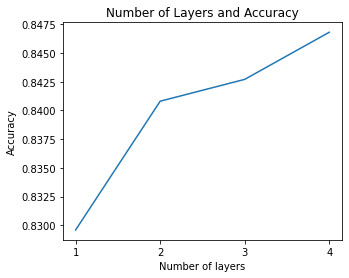

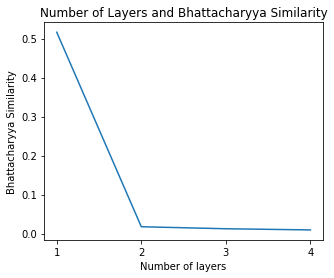

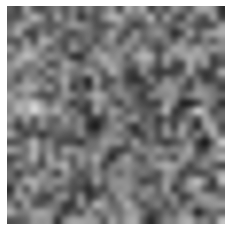

In [15]:
feature_models, accuracies, bhattacharyyas, layer_pred = cache

get_plot(accuracies, 
         title='Number of Layers and Accuracy',
         xlabel='Number of layers',
         ylabel='Accuracy')

get_plot(bhattacharyyas, 
         title='Number of Layers and Bhattacharyya Similarity',
         xlabel='Number of layers',
         ylabel='Bhattacharyya Similarity')

visualize_array(target_layer.get_weights()[0])

## Training Set Results

In [16]:
# NOTE: _o means correct and _x means incorrect and can be read as
#       "for those that were incorrectly classified"

out = get_eval_datasets(data = x_train, 
                        labels = y_train, 
                        predictions = y_pred_train)

x_train_o, y_pred_train_o, x_train_x, y_pred_train_x, y_true_train_x = out

In [17]:
num_classes = 10
accuracies_per_label_train = calculate_acc_for_labels(all_labels = y_train,
                                                      correct_labels = y_pred_train_o,
                                                      num_classes = num_classes,
                                                      labels = [])

In [18]:
accuracies_per_label_train

{0: 0.8201342281879195,
 1: 0.959349593495935,
 2: 0.7431286053613845,
 3: 0.8820224719101124,
 4: 0.8313212608987257,
 5: 0.9826839826839827,
 6: 0.6530612244897959,
 7: 0.8472498343273691,
 8: 0.9690860215053764,
 9: 0.946513202437373}

## Test Set Results

In [19]:
# NOTE: _o means correct and _x means incorrect and can be read as
#       "for those that were incorrectly classified"

out = get_eval_datasets(data = x_test, 
                        labels = y_test, 
                        predictions = y_pred)

x_test_o, y_pred_o, x_test_x, y_pred_x, y_true_x = out

In [20]:
accuracies_per_label_test = calculate_acc_for_labels(all_labels = y_test,
                                                     correct_labels = y_pred_o,
                                                     num_classes = num_classes,
                                                     labels = [])

In [21]:
accuracies_per_label_test

{0: 0.768,
 1: 0.943,
 2: 0.704,
 3: 0.866,
 4: 0.797,
 5: 0.972,
 6: 0.628,
 7: 0.846,
 8: 0.966,
 9: 0.928928928928929}

## Identify Problematic Labels

In [23]:
underfit_labels = get_underfit_labels(acc = accuracies_per_label_train,
                                      num_classes = num_classes,
                                      threshold = theta,
                                      labels = []) 

print(underfit_labels)

{2: 0.7431286053613845, 6: 0.6530612244897959}


In [24]:
get_faultiest_label(underfit_labels)

6

In [25]:
overfit_labels = get_overfit_labels(train_acc = accuracies_per_label_train,
                                    test_acc = accuracies_per_label_test,
                                    num_classes = num_classes,
                                    threshold = gamma,
                                    labels = [])

print(overfit_labels)

No overfit labels...
{}


## Get Heatmaps

In [26]:
labels, heatmaps = get_heatmaps(correct_data = x_test_o,
                                correct_labels = y_pred_o,
                                misclassified_data = x_test_x, 
                                misclassified_labels = y_pred_x, 
                                misclassified_correct_labels = y_true_x, 
                                num_classes = num_classes,
                                labels = [], 
                                type = 'hci')

## Get Next Batch

Bug Fixing Pool - # of samples remaining: 28000
1


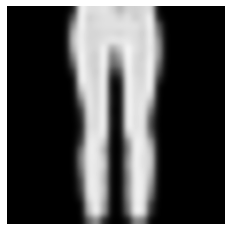

In [27]:
next_X, next_y, x_bug_fixes, y_bug_fixes = select_next_inputs(bug_fix_data = x_bug_fixes,
                                                              bug_fix_labels = y_bug_fixes,
                                                              heatmaps = heatmaps,
                                                              target_label = 1,
                                                              batch_size = batch_size,
                                                              ratio = alpha,
                                                              for_underfitting=True,
                                                              distance_metric='dot')
# check out an example of a desirable target
print(next_y[0])
visualize_array(next_X[0])

## Targeted Label Retraining

0. Train model on all training data and evaluate performance on test data. 


1. Starting with underfitting first, select the target layer that enters a saturation point. 
2. Use the predictions of the target layer, generate heatmaps for each label.
3. Calculate the per-label accuracy.
4. Select the most faulty label for retraining (break if none). 
5. Generate a batch tailored to improving performance on that label.
6. Train on this new batch
7. Evaluate performance
8. Return to 1 and repeat until there are no more faulty underfitting labels


9. Select the most faulty overfitting label
10. Use the predictions of the target layer, generate heatmaps for each label.
11. Calculate the per-label accuracy.
12. Select the most faulty label for retraining (break if none). 
13. Generate a batch tailored to improving performance on that label.
14. Train on this new batch
15. Evaluate performance
16. Return to 1 and repeat until there are no more faulty underfitting labels


17. Check if there are anymore underfitting labels, if so, return to 1

In [28]:
import time

max_iter = 5

num_classes = 10
# download MNIST
mnist = tf.keras.datasets.fashion_mnist

# split into test and train sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize to [0,1] by dividing by the max value
x_train, x_test = x_train / 255.0, x_test / 255.0

# further split x_train and y_train into new training and bug fixing sets (50/50)
from sklearn.model_selection import train_test_split
x_train, x_bug_fixes, y_train, y_bug_fixes = train_test_split(x_train, y_train, test_size=0.5, random_state=123)

print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)

print('Bug Fixing data shape: ', x_bug_fixes.shape)
print('Bug Fixing labels shape: ', y_bug_fixes.shape)

print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

# create model layers
model = k.models.Sequential([
  k.layers.Flatten(input_shape=(28, 28)),
  k.layers.Dense(28, activation=tf.nn.relu),
  k.layers.Dense(28, activation=tf.nn.relu),
  k.layers.Dense(28, activation=tf.nn.relu),
  k.layers.Dense(10, activation=tf.nn.softmax)
])

# compile with optimizer, loss, and metrics
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# fit
model.fit(x_train, y_train, epochs=epochs)

# predict test (to get distributions)
y_pred = model.predict(x_test)

# test
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Initial Test Loss: {}, Initial Test Accuracy: {}'.format(test_loss, test_acc))


control_model = replicate_model(model)

control_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

start = time.time()

i = 0
while i < max_iter:

    # control model with no specialized batch selection
    control_batch_x, control_batch_y = x_bug_fixes[:batch_size], y_bug_fixes[:batch_size]
    control_model.fit(control_batch_x, control_batch_y, epochs=epochs, verbose=0)

    # identify target layer
    print('Identifying target layer...')
    target_layer, cache = Forward_Layer_Select(model, 
                                               x_train, 
                                               y_train, 
                                               x_test, 
                                               y_test, 
                                               epochs, 
                                               similarity_threshold, 
                                               verbose=False)

    feature_models, accuracies, bhattacharyyas, layer_pred = cache

    # breakout eval sets
    out = get_eval_datasets(data = x_test, 
                            labels = y_test, 
                            predictions = layer_pred)

    data_correct, labels_correct, data_incorrect, labels_incorrect, labels_corrected = out

    # generate heatmaps
    labels, heatmaps = get_heatmaps(correct_data = data_correct,
                                    correct_labels = labels_correct,
                                    misclassified_data = data_incorrect, 
                                    misclassified_labels = labels_incorrect, 
                                    misclassified_correct_labels = labels_corrected, 
                                    num_classes = num_classes,
                                    labels = [], 
                                    type = 'hci')

    # identify buggy labels
    accuracies_per_label_target = calculate_acc_for_labels(all_labels = y_test,
                                                           correct_labels = labels_correct,
                                                           num_classes = num_classes,
                                                           labels = [])
    
    underfit_labels = get_underfit_labels(acc = accuracies_per_label_target,
                                          num_classes = num_classes,
                                          threshold = theta,
                                          labels = []) 


    # select the most faulty underfitting label
    if len(underfit_labels) > 0:
        faultiest_label = get_faultiest_label(underfit_labels)
        print('Creating a batch for faultiest label: {}. There are {} faulty labels in total...'.format(faultiest_label, 
                                                                                                       len(underfit_labels)))
        print('Faulty labels: ', underfit_labels)
    else:
        print('MODE retraining complete!')
        break

    # generate a batch tailored to improving performance on that label
    next_X, next_y, x_bug_fixes, y_bug_fixes = select_next_inputs(bug_fix_data = x_bug_fixes,
                                                                  bug_fix_labels = y_bug_fixes,
                                                                  heatmaps = heatmaps,
                                                                  target_label = faultiest_label,
                                                                  batch_size = batch_size,
                                                                  ratio = alpha,
                                                                  for_underfitting = True,
                                                                  distance_metric = 'dot')

    # train on this new batch
    model.fit(next_X, next_y, epochs=epochs, verbose=1)

    # evaluate performance
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

    # repeat until there are no more faulty underfitting labels
    i += 1

    print('{} iterations left...\n'.format(max_iter - i))

print('Control model performance to beat:')  
control_loss, control_acc = control_model.evaluate(x_test, y_test, verbose=0)
print('Control Test Loss: {}, Control Test Accuracy: {}'.format(control_loss, control_acc))

print('That took {} seconds'.format(time.time() - start))

Training data shape:  (30000, 28, 28)
Training labels shape:  (30000,)
Bug Fixing data shape:  (30000, 28, 28)
Bug Fixing labels shape:  (30000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)
Epoch 1/3
938/938 [==============================] - 3s 2ms/step - loss: 0.6717 - accuracy: 0.7608
Epoch 2/3
938/938 [==============================] - 2s 2ms/step - loss: 0.4463 - accuracy: 0.8407
Epoch 3/3
938/938 [==============================] - 2s 2ms/step - loss: 0.4022 - accuracy: 0.8554
Initial Test Loss: 0.43548423051834106, Initial Test Accuracy: 0.8425999879837036
Identifying target layer...
Target Layer # 4: <keras.layers.core.dense.Dense object at 0x7fa6040b9410>
Creating a batch for faultiest label: 6. There are 2 faulty labels in total...
Faulty labels:  {4: 0.733, 6: 0.603}
Bug Fixing Pool - # of samples remaining: 28000
Epoch 1/3
63/63 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.8525
Epoch 2/3
63/63 [==============================]

## Visualizations

True Label: 0 Prediction: 3


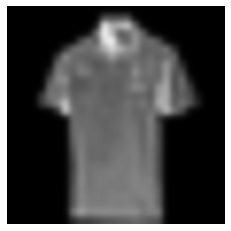

In [35]:
sample_misclassifications(misclassified_data = x_test_x, 
                          misclassified_labels = y_pred_x, 
                          misclassified_correct_labels = y_true_x, 
                          num_samples=1, 
                          shuffle=True)

In [36]:
viz_heatmaps_for_correct_prediction(correct_data = x_test_o,
                                    correct_labels = y_pred_o,
                                    num_classes = num_classes,
                                    labels = [],
                                    cmap = 'seismic')

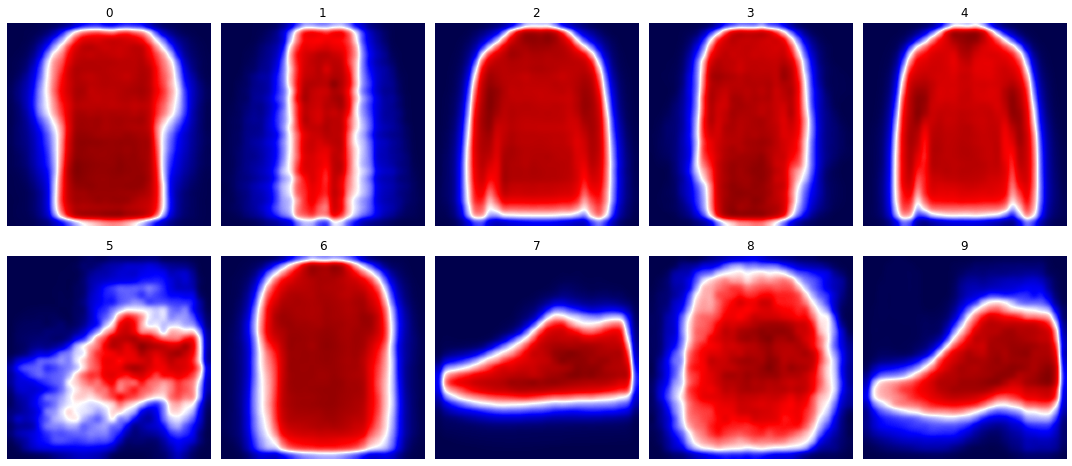

In [37]:
viz_heatmaps_for_false_positives(misclassified_data = x_test_x, 
                                 misclassified_correct_labels = y_true_x, 
                                 num_classes = num_classes,
                                 cmap='seismic')

In [39]:
viz_heatmaps_for_false_negatives(misclassified_data = x_test_x, 
                                 misclassified_labels = y_pred_x, 
                                 num_classes = num_classes,
                                 cmap='seismic')

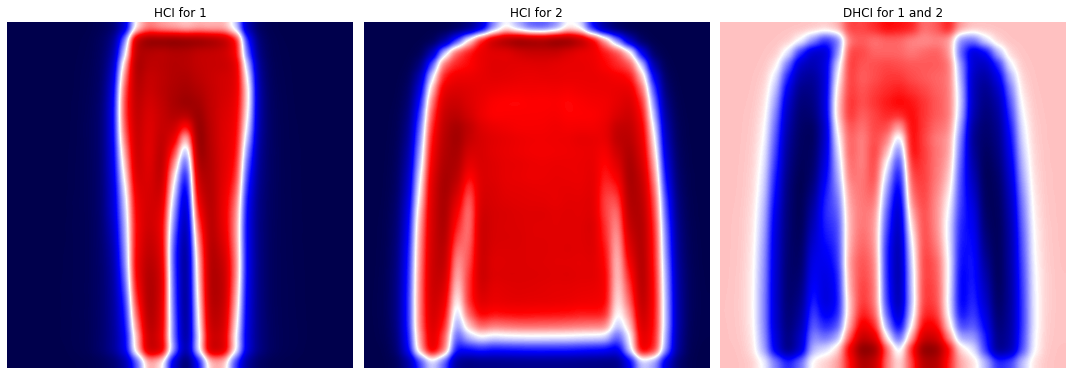

In [40]:
DHCI_i_k(correct_data = x_test_o,
         correct_labels = y_pred_o,
         first_label = 1, 
         second_label = 2,
         cmap='seismic')

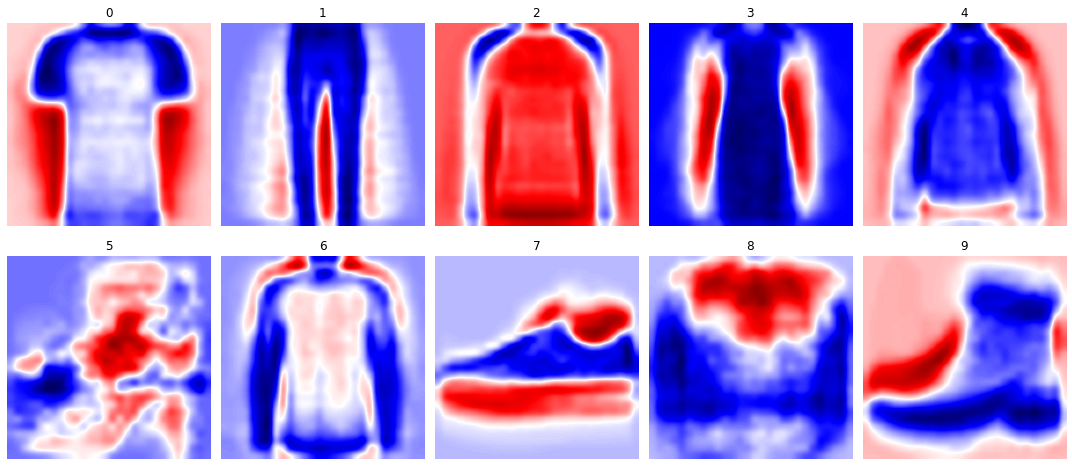

In [41]:
DHMI_i(correct_data = x_test_o,
       correct_labels = y_pred_o,
       misclassified_data = x_test_x,
       misclassified_correct_labels = y_true_x, 
       num_classes = num_classes,
       cmap='seismic')

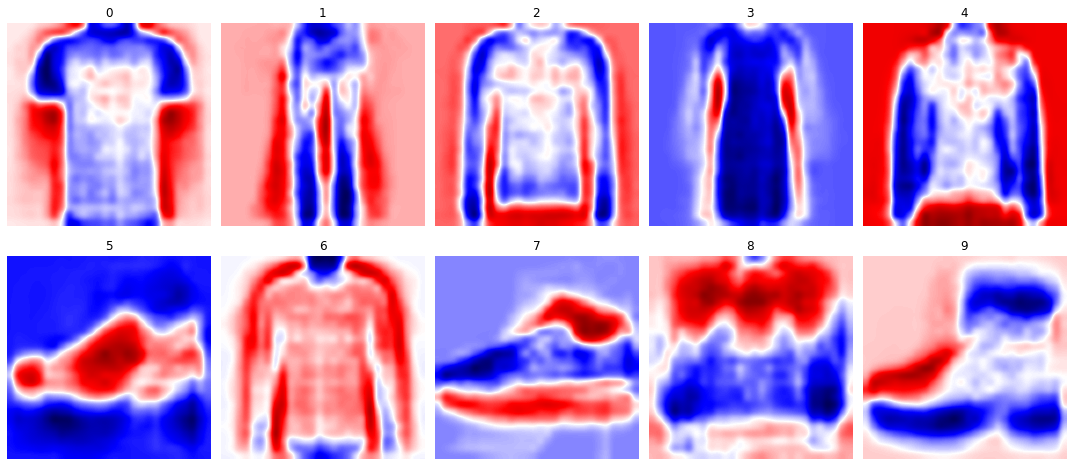

In [42]:
DHWI_i(correct_data = x_test_o,
       correct_labels = y_pred_o,
       misclassified_data = x_test_x,
       misclassified_labels = y_pred_x, 
       num_classes = num_classes,
       cmap='seismic')

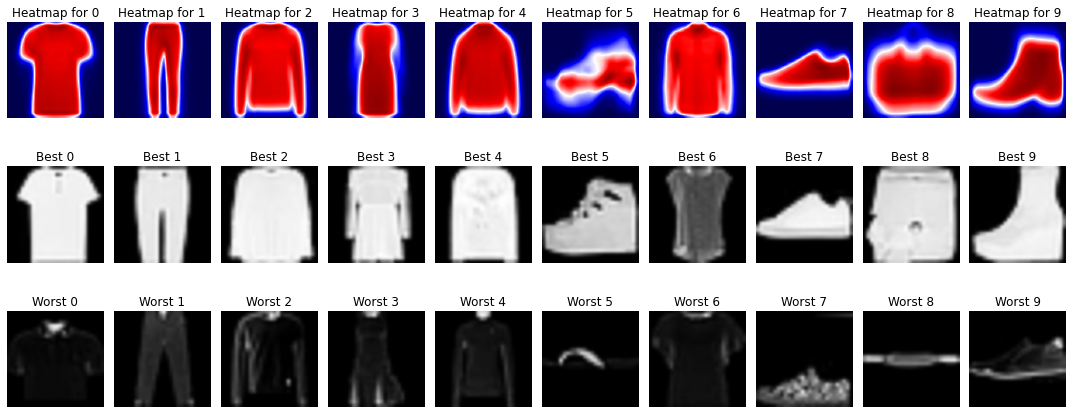

In [43]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='dot')

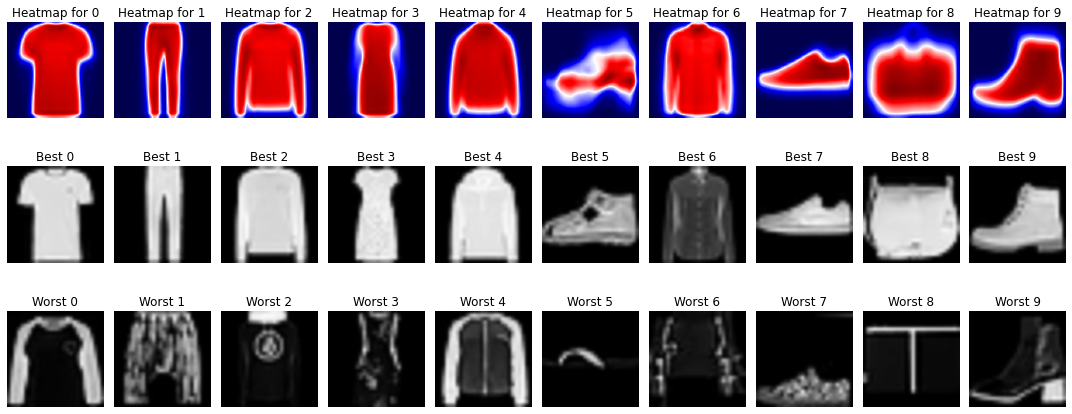

In [44]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='cosine')

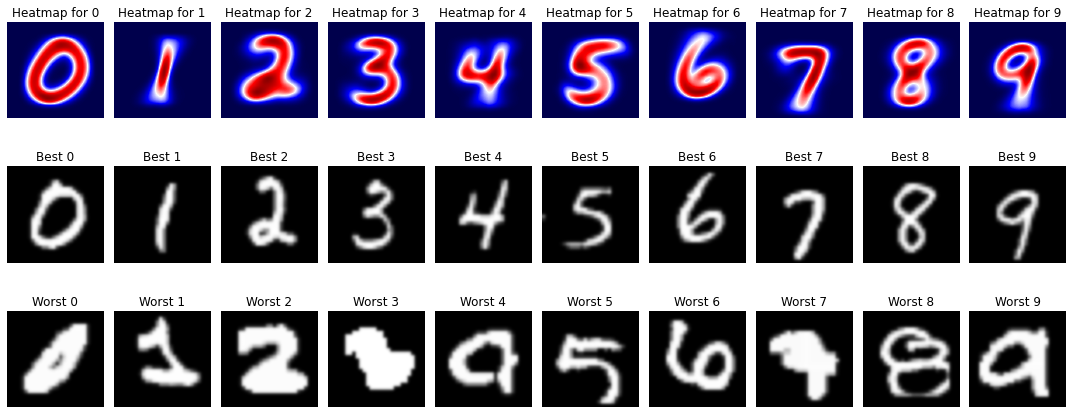

In [ ]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='euclidean')

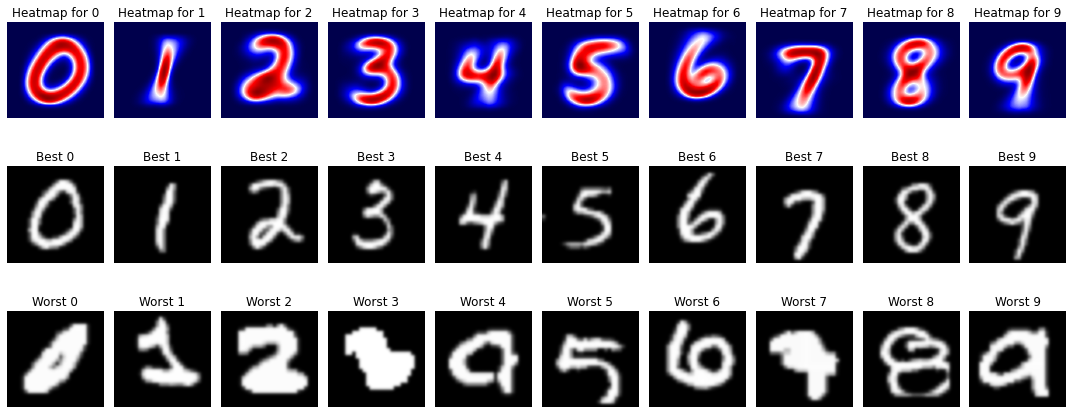

In [ ]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='manhattan')

Defaut minkowski_power = 3 set...


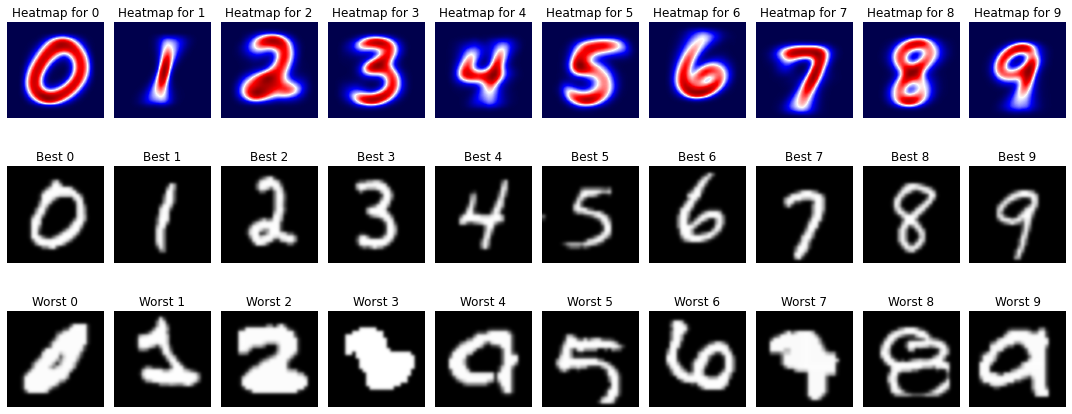

In [ ]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='minkowski')

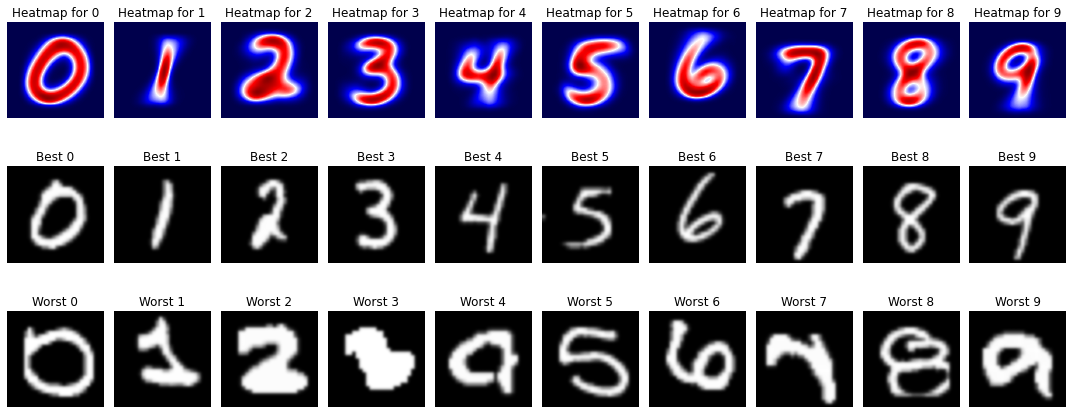

In [ ]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='minkowski',
                       minkowski_power=5)

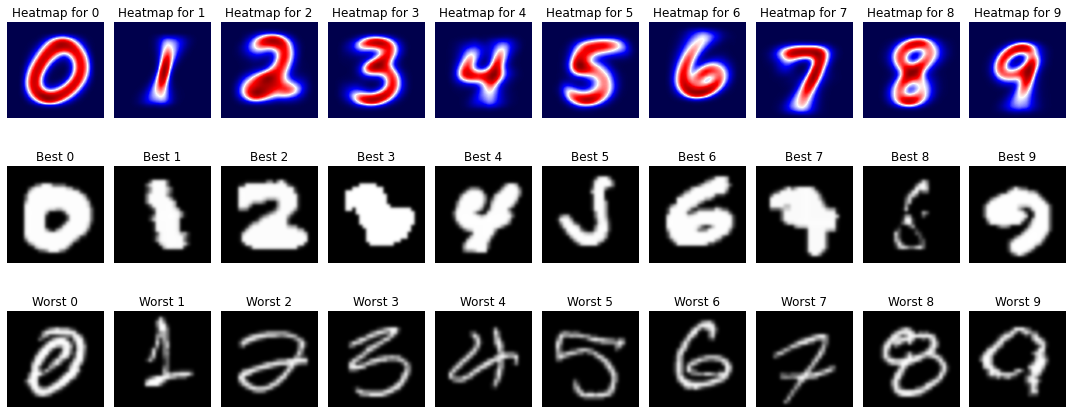

In [ ]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='earthmover')

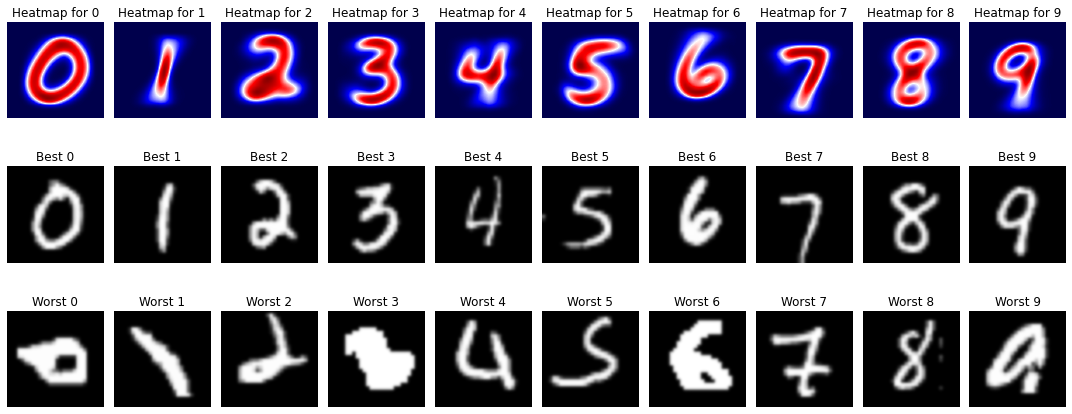

In [ ]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='chebyshev')

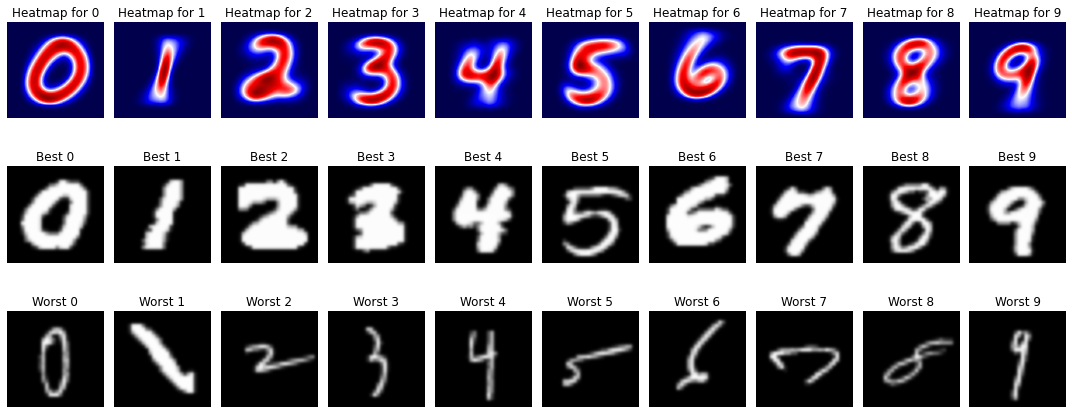

In [ ]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='canberra')

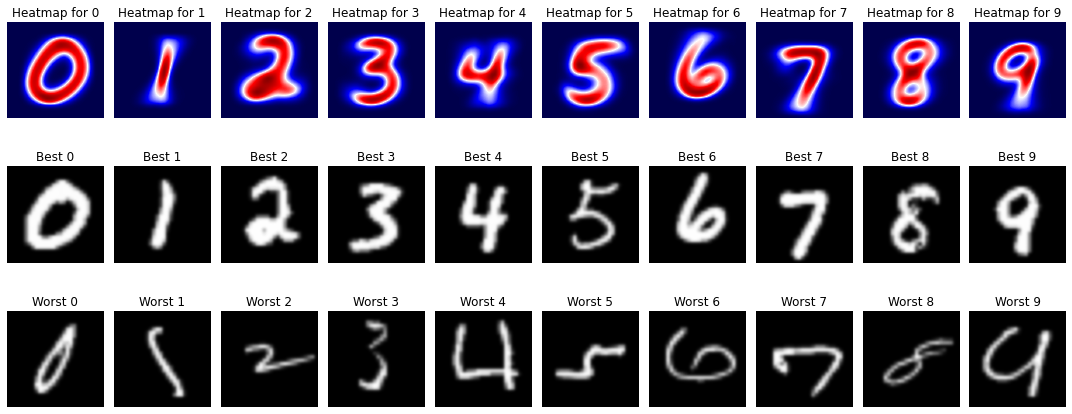

In [ ]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='braycurtis')

Defaut minkowski_power = 3 set...


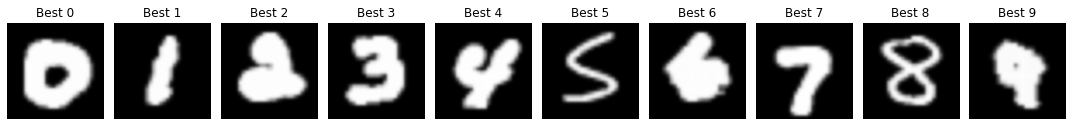

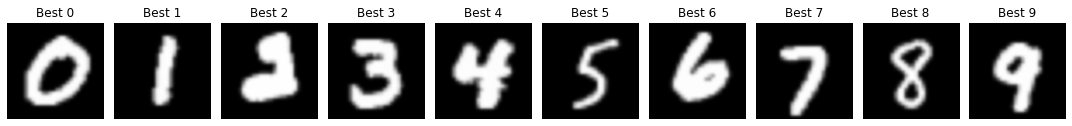

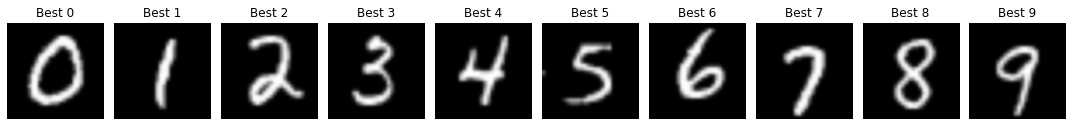

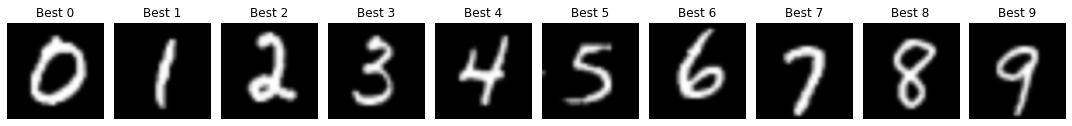

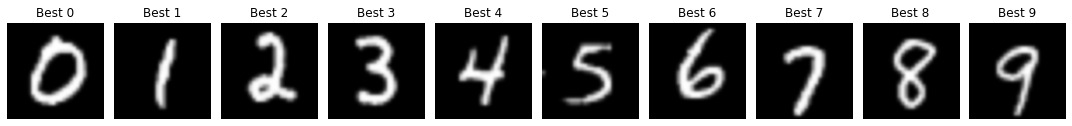

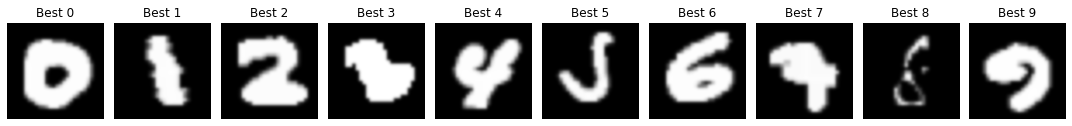

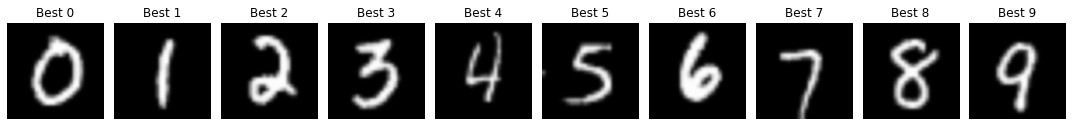

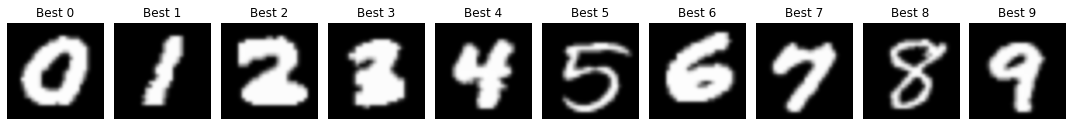

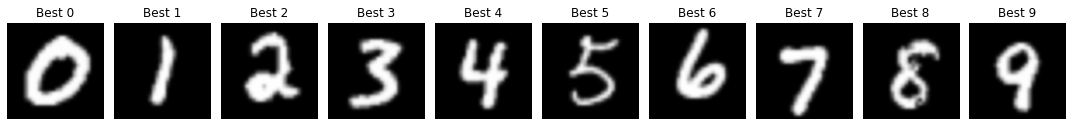

In [ ]:
for distance_metric in distance_metrics:

    viz_most_similar(bug_fix_data = x_bug_fixes,
                     bug_fix_labels = y_bug_fixes,
                     labels = labels,
                     heatmaps = heatmaps,
                     distance_metric=distance_metric)

Defaut minkowski_power = 3 set...


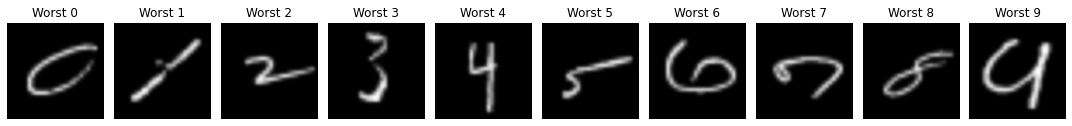

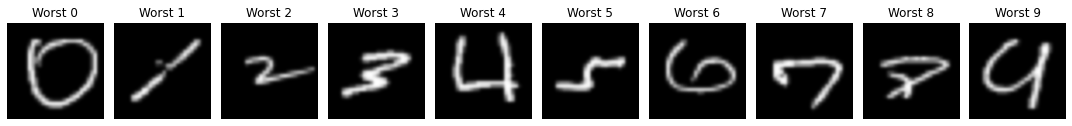

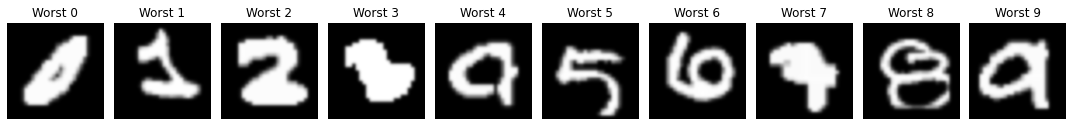

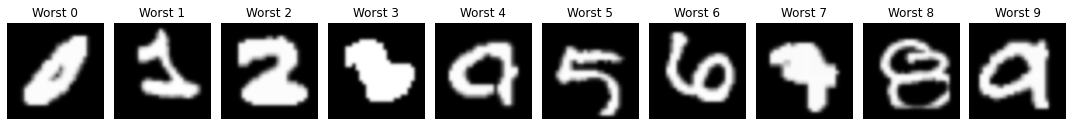

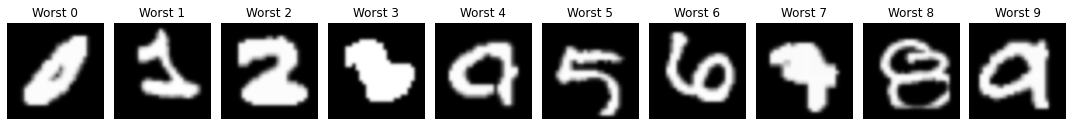

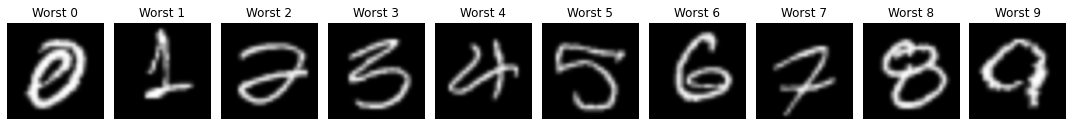

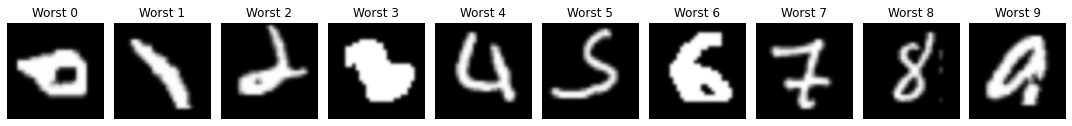

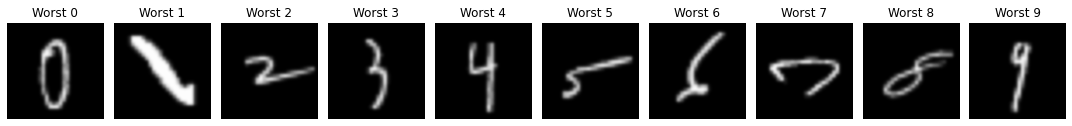

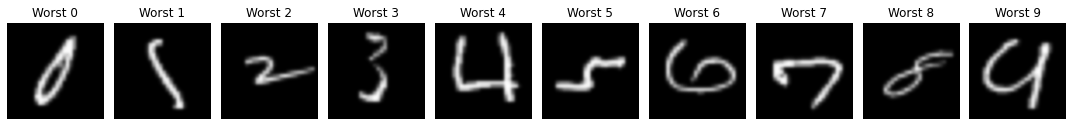

In [ ]:
for distance_metric in distance_metrics:

    viz_least_similar(bug_fix_data = x_bug_fixes,
                     bug_fix_labels = y_bug_fixes,
                     labels = labels,
                     heatmaps = heatmaps,
                     distance_metric=distance_metric)